In [40]:
!pip install keras-segmentation


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 34.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.3/753.3 kB 18.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 84.9 MB/s eta 0:00:00:00:0100:01
  Created wheel for keras-segmentation: filename=keras_segmentation-0.3.0-py3-none-any.whl size=29059 sha256=00c1375d455f5ac0f605871e225007318657b9f016c500c9dccc4541b659ed54
  Stored in directory: /root/.cache/pip/wheels/2a/87/5b/ddc104c262fe1280e0565a2cc1b9b6b04963af12e462cdf068
Successfully built keras-segmentation
  Attempting uninstall: imageio
    Found existing installation: imageio 2.33.1
    Uninstalling imageio-2.33.1:
      Successfully uninstalled imageio-2.33.1
  Attempting uninstall: scikit-image
    Found existing installation:

In [41]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn
import cv2 as cv
import nibabel as nib
import pickle
import imgaug as ia
import imgaug.augmenters as iaa
import tqdm
import gc
import warnings
import tensorflow as tf
from keras import backend as K
from keras import losses, metrics
from keras import optimizers
from keras import callbacks
from keras.models import Model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Multiply
from sklearn.model_selection import train_test_split
import keras_segmentation as ks

In [42]:
metadata = pd.read_csv('/kaggle/input/covid19-ct-scans/metadata.csv')
print(metadata.shape)#A total of 20 data sets
metadata.head()

(20, 4)


,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
3,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
4,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [43]:
img_size = 128
clahe = cv.createCLAHE(clipLimit=3.0)
def clahe_enhancer(img, clahe, axes):
    img = np.uint8(img*255)  
    clahe_img = clahe.apply(img)

    if len(axes) > 0 :    
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])

        axes[1].imshow(clahe_img, cmap='bone')
        axes[1].set_title("CLAHE Enhanced CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        if len(axes) > 2 :
            axes[2].hist(img.flatten(), alpha=0.4, label='Original CT scan')
            axes[2].hist(clahe_img.flatten(), alpha=0.4, label="CLAHE Enhanced CT scan")
            plt.legend()
        
    return(clahe_img)


Number of slices:  301


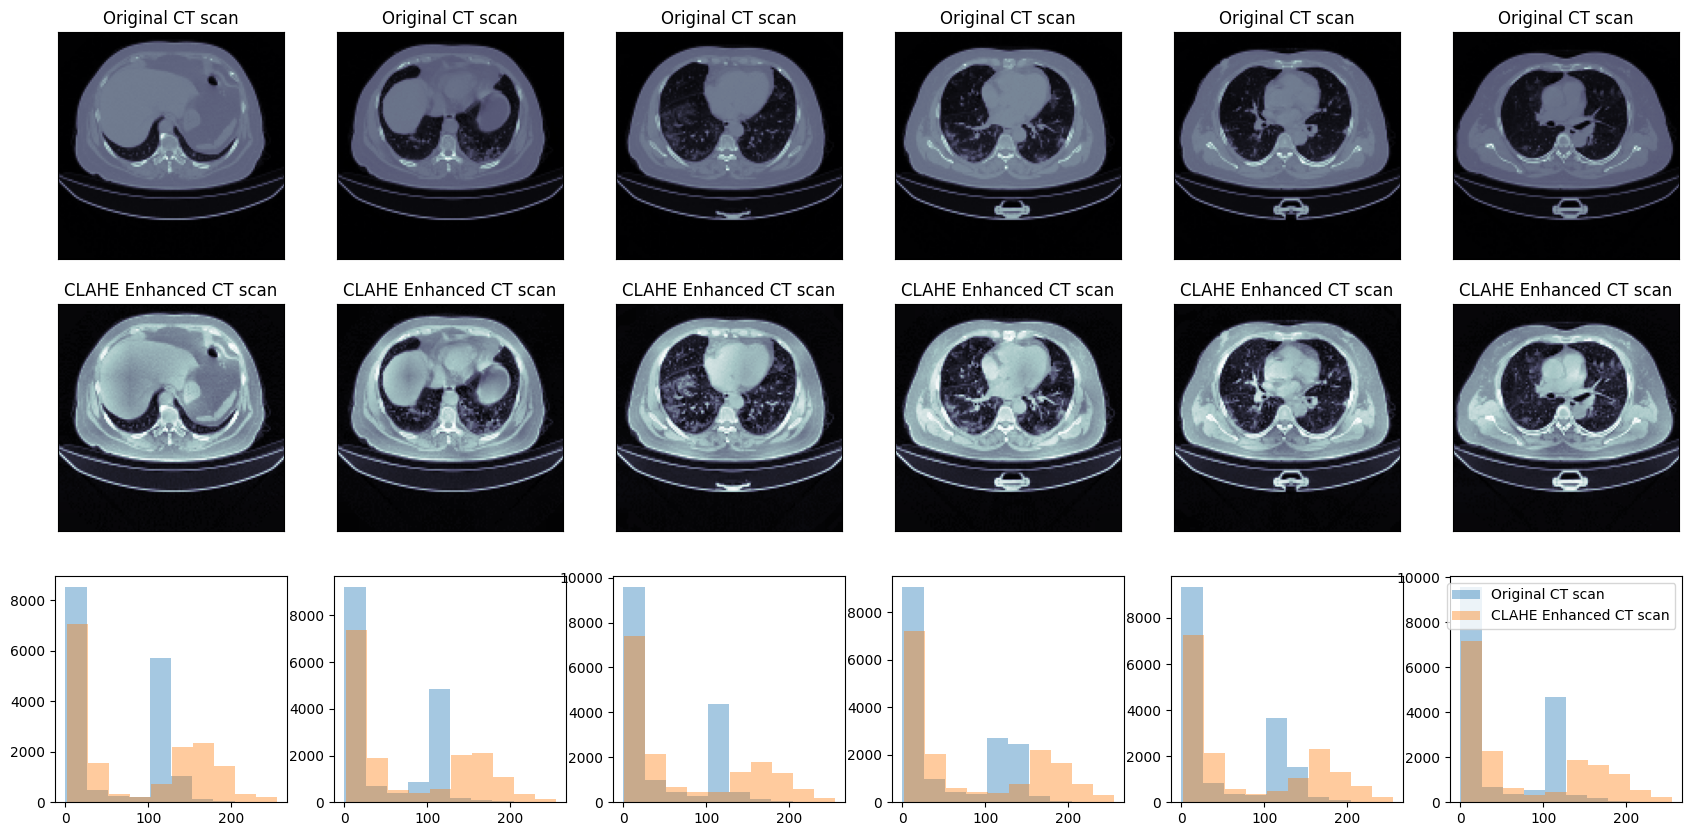

In [44]:
cts = nib.load(metadata.loc[0, 'ct_scan'])

slices = cts.shape[2]
print('Number of slices: ', slices)

#Select display image
arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))
fig, axes = plt.subplots(3, 6, figsize=(21,10))  
for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)#Picture normalization
    clahe_img = clahe_enhancer(img, clahe, list(axes[:, ii]))

In [45]:
def get_contours(img):
    img = np.uint8(img*255)
    
    kernel = np.ones((3,3),np.float32)/9
    img = cv.filter2D(img, -1, kernel)
    
    ret, thresh = cv.threshold(img, 50, 255, cv.THRESH_BINARY)
    contours, hierarchy = cv.findContours(thresh, 2, 1)
    
    size = get_size(img)
    contours = [cc for cc in contours if contourOK(cc, size)]
    return contours

def get_size(img):
    ih, iw = img.shape
    return iw * ih

def contourOK(cc, size):
    x, y, w, h = cv.boundingRect(cc)
    if ((w < 50 and h > 150) or (w > 150 and h < 50)) : 
        return False # too narrow or wide is bad
    area = cv.contourArea(cc)
    return area < (size * 0.5) and area > 200
def find_boundaries(img, contours):
    ih, iw = img.shape
    minx = iw
    miny = ih
    maxx = 0
    maxy = 0

    for cc in contours:
        x, y, w, h = cv.boundingRect(cc)
        if x < minx: minx = x
        if y < miny: miny = y
        if x + w > maxx: maxx = x + w
        if y + h > maxy: maxy = y + h

    return (minx, miny, maxx, maxy)

def crop_(img, boundaries):
    minx, miny, maxx, maxy = boundaries
    return img[miny:maxy, minx:maxx]
    
def crop_img(img, axes) :
    contours = get_contours(img)

    bounds = find_boundaries(img, contours)
    cropped_img = crop_(img, bounds)
    if len(axes) > 0 :
        axes[0].imshow(img, cmap='bone')
        axes[0].set_title("Original CT scan")
        axes[0].set_xticks([]); axes[0].set_yticks([])
        
        axes[1].imshow(cropped_img, cmap='bone')
        axes[1].set_title("Cropped CT scan")
        axes[1].set_xticks([]); axes[1].set_yticks([])
        
    return cropped_img, bounds


Number of slices:  301


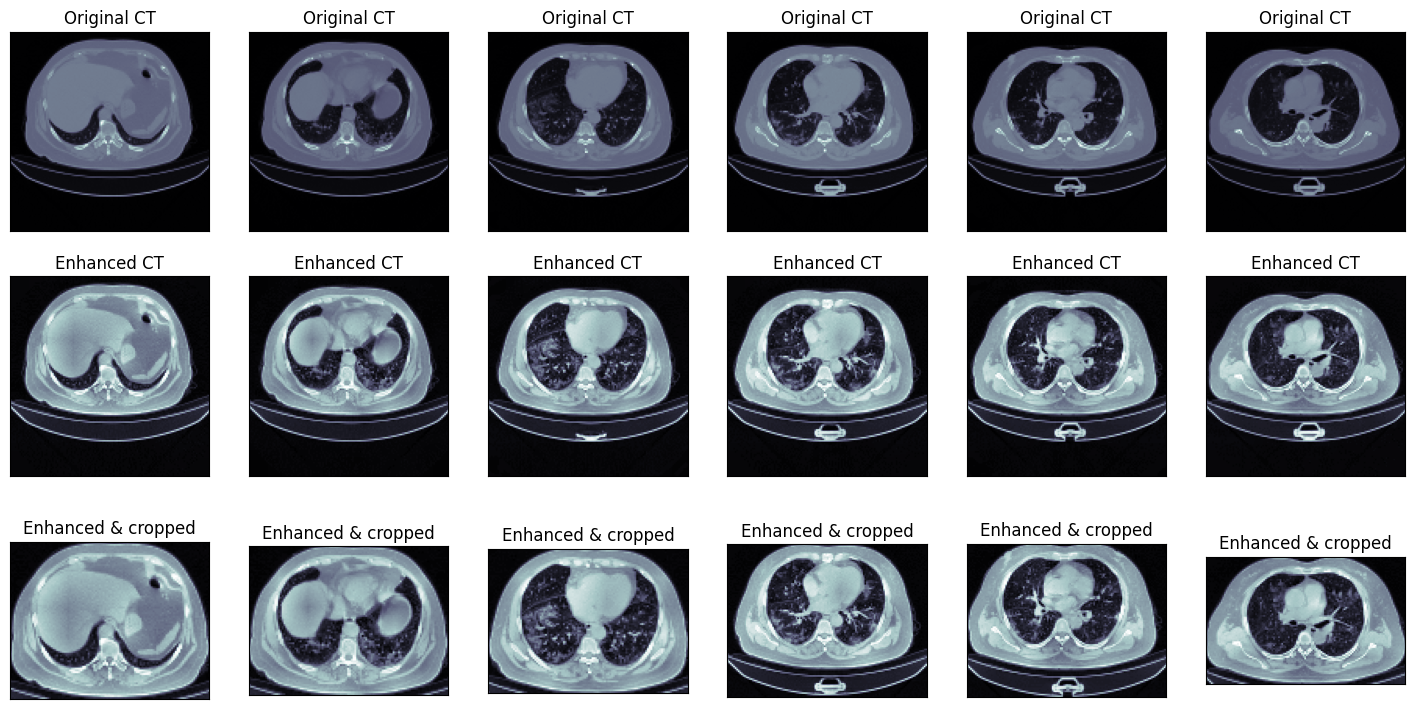

In [46]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
slices = cts.shape[2]
print('Number of slices: ', slices)
    
arr = cts.get_fdata()
arr = np.rot90(np.array(arr))
arr = arr[:,:,range(80,200,20)]
arr = np.reshape(np.rollaxis(arr, 2),(arr.shape[2],arr.shape[0],arr.shape[1], 1))

fig, axes = plt.subplots(3, 6, figsize=(18,9))    

for ii in range(arr.shape[0]):
    img = cv.resize(arr[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    xmax, xmin = img.max(), img.min()
    img = (img - xmin)/(xmax - xmin)#Image normalization
    _, bounds = crop_img(img, [])#
    axes[0,ii].imshow(img, cmap='bone')
    axes[0,ii].set_title('Original CT')#The original image
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    clahe_img = clahe_enhancer(img, clahe, [])#Equalize the image
    axes[1,ii].imshow(clahe_img, cmap='bone')
    axes[1,ii].set_title('Enhanced CT')
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])
    
    cropped_img = crop_(clahe_img, bounds)#Crop the equalized image to remove unnecessary borders
    axes[2,ii].imshow(cropped_img, cmap='bone')
    axes[2,ii].set_title('Enhanced & cropped')
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

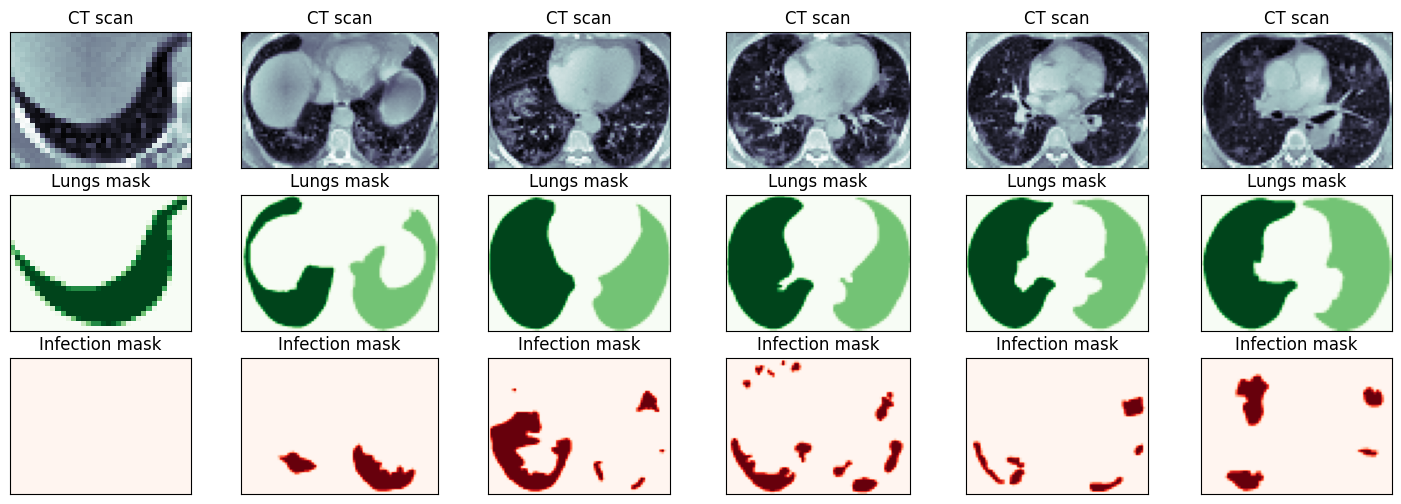

In [47]:
cts = nib.load(metadata.loc[0, 'ct_scan'])
lungs = nib.load(metadata.loc[0, 'lung_mask'])
infec = nib.load(metadata.loc[0, 'infection_mask'])
slices = cts.shape[2]
    
arr_cts = cts.get_fdata()
arr_lungs = lungs.get_fdata()
arr_infec = infec.get_fdata()

arr_cts = np.rot90(np.array(arr_cts))
arr_lungs = np.rot90(np.array(arr_lungs))
arr_infec = np.rot90(np.array(arr_infec))

arr_cts = arr_cts[:, :, range(80,200,20)]
arr_lungs = arr_lungs[:, :, range(80,200,20)]
arr_infec = arr_infec[:, :, range(80,200,20)]

arr_cts = np.reshape(np.rollaxis(arr_cts, 2), 
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), 
                     (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
arr_infec = np.reshape(np.rollaxis(arr_infec, 2), 
                     (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))
fig, axes = plt.subplots(3, 6, figsize=(18,6))    

for ii in range(arr_cts.shape[0]):
    img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    img_lungs = cv.resize(arr_lungs[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)
    img_infec = cv.resize(arr_infec[ii], dsize=(img_size, img_size), interpolation=cv.INTER_AREA)

    xmax, xmin = img_lungs.max(), img_lungs.min()
    img_lungs = (img_lungs - xmin)/(xmax - xmin)
    cropped_lungs, bounds = crop_img(img_lungs, [])
    
    xmax, xmin = img_ct.max(), img_ct.min()
    img_ct = (img_ct - xmin)/(xmax - xmin)
    clahe_ct = clahe_enhancer(img_ct, clahe, [])
    cropped_ct = crop_(clahe_ct, bounds)
    cropped_infec = crop_(img_infec, bounds)
    
    axes[0,ii].imshow(cropped_ct, cmap='bone')
    axes[0,ii].set_title("CT scan")
    axes[0,ii].set_xticks([]); axes[0,ii].set_yticks([])
    
    axes[1,ii].imshow(cropped_lungs, cmap='Greens')
    axes[1,ii].set_title("Lungs mask")
    axes[1,ii].set_xticks([]); axes[1,ii].set_yticks([])

    axes[2,ii].imshow(cropped_infec, cmap='Reds')
    axes[2,ii].set_title("Infection mask")
    axes[2,ii].set_xticks([]); axes[2,ii].set_yticks([])

In [48]:
cts_all = []
lungs_all = []
infects_all = []
max_w, max_h = 0, 0 

for fnum in tqdm.tqdm(range(20)) : 
    cts = nib.load(metadata.loc[fnum, 'ct_scan'])
    lungs = nib.load(metadata.loc[fnum, 'lung_mask'])
    infec = nib.load(metadata.loc[fnum, 'infection_mask'])
    
    slices = cts.shape[2]

    arr_cts = cts.get_fdata()
    arr_lungs = lungs.get_fdata()
    arr_infec = infec.get_fdata()

    arr_cts = np.rot90(np.array(arr_cts))
    arr_lungs = np.rot90(np.array(arr_lungs))
    arr_infec = np.rot90(np.array(arr_infec))

    arr_cts = arr_cts[:, :, round(slices*0.2):round(slices*0.8)]
    arr_lungs = arr_lungs[:, :, round(slices*0.2):round(slices*0.8)]
    arr_infec = arr_infec[:, :, round(slices*0.2):round(slices*0.8)]

    arr_cts = np.reshape(np.rollaxis(arr_cts, 2), 
                     (arr_cts.shape[2],arr_cts.shape[0],arr_cts.shape[1], 1))
    arr_lungs = np.reshape(np.rollaxis(arr_lungs, 2), 
                     (arr_lungs.shape[2],arr_lungs.shape[0],arr_lungs.shape[1], 1))
    arr_infec = np.reshape(np.rollaxis(arr_infec, 2), 
                     (arr_infec.shape[2],arr_infec.shape[0],arr_infec.shape[1], 1))
    for ii in range(arr_cts.shape[0]):
        img_lungs = cv.resize(arr_lungs[ii], dsize=(img_size, img_size), 
                              interpolation=cv.INTER_AREA)
        xmax, xmin = img_lungs.max(), img_lungs.min()
        img_lungs = (img_lungs - xmin)/(xmax - xmin)
        cropped_lungs, bounds = crop_img(img_lungs, [])
        lungs_all.append(cropped_lungs)
        
        h, w = cropped_img.shape
        max_h, max_w = max(max_h, h), max(max_w, w)

        img_ct = cv.resize(arr_cts[ii], dsize=(img_size, img_size), 
                           interpolation=cv.INTER_AREA)
        xmax, xmin = img_ct.max(), img_ct.min()
        img_ct = (img_ct - xmin)/(xmax - xmin)
        clahe_ct = clahe_enhancer(img_ct, clahe, [])
        cropped_ct = crop_(clahe_ct, bounds)
        cts_all.append(cropped_ct)

        img_infec = cv.resize(arr_infec[ii], dsize=(img_size, img_size), 
                              interpolation=cv.INTER_AREA)
        cropped_infec = crop_(img_infec, bounds)
        infects_all.append(cropped_infec)


 45%|████▌     | 9/20 [00:23<00:30,  2.75s/it]/tmp/ipykernel_35/993912985.py:35: RuntimeWarning: invalid value encountered in divide
  img_lungs = (img_lungs - xmin)/(xmax - xmin)
/tmp/ipykernel_35/16810527.py:2: RuntimeWarning: invalid value encountered in cast
  img = np.uint8(img*255)
100%|██████████| 20/20 [00:42<00:00,  2.10s/it]


In [49]:
print(len(cts_all))


2112


In [50]:
num_pix = 100
del_lst = []
for ii in tqdm.tqdm(range(len(cts_all))) :
    try :
        cts_all[ii] = cv.resize(cts_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        cts_all[ii] = np.reshape(cts_all[ii], (num_pix, num_pix, 1))

        lungs_all[ii] = cv.resize(lungs_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        lungs_all[ii] = np.reshape(lungs_all[ii], (num_pix, num_pix, 1))

        infects_all[ii] = cv.resize(infects_all[ii], dsize=(num_pix, num_pix), interpolation=cv.INTER_AREA)
        infects_all[ii] = np.reshape(infects_all[ii], (num_pix, num_pix, 1))
    except :
        del_lst.append(ii)
        
for idx in del_lst[::-1] :
    del cts_all[idx]
    del lungs_all[idx]
    del infects_all[idx]

100%|██████████| 2112/2112 [00:00<00:00, 9655.06it/s]


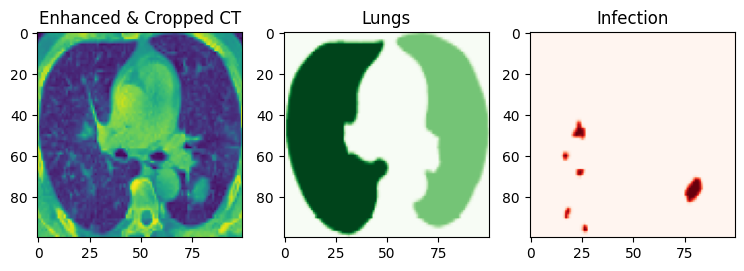

In [51]:
fig, axes = plt.subplots(1, 3, figsize=(9,3))

axes[0].imshow(cts_all[250][:, :, 0])
axes[0].set_title("Enhanced & Cropped CT")

axes[1].imshow(lungs_all[250][:, :, 0], cmap='Greens')
axes[1].set_title("Lungs")

axes[2].imshow(infects_all[250][:, :, 0], cmap='Reds')
axes[2].set_title("Infection");

In [52]:
with open('preprocessed_cts.cp', 'wb') as myfile:
    pickle.dump({'cts_all': cts_all, 'lungs_all': lungs_all, 'infects_all': infects_all}, myfile)


In [53]:
infect_bool = np.ones((1, len(infects_all)))
for ii in range(len(infects_all)):
    if np.unique(infects_all[ii]).size == 1:
        infect_bool[0, ii] = 0
        
print("Number of CTs with no infection: %d" %(len(infects_all)-infect_bool.sum()))


Number of CTs with no infection: 474


In [54]:
import torch
from torch import Tensor
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import tarfile
from torchvision.datasets import ImageFolder
from PIL import Image, ImageEnhance
import numpy as np
from torchvision import models
!pip install torchsummary --quiet
from torchsummary import summary
import time

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [55]:
root_dir="/kaggle/input/caltech256/256_objectcategories/256_ObjectCategories/"


In [56]:
enhancers = {
    0: lambda image, f: ImageEnhance.Color(image).enhance(f),
    1: lambda image, f: ImageEnhance.Contrast(image).enhance(f),
    2: lambda image, f: ImageEnhance.Brightness(image).enhance(f),
    3: lambda image, f: ImageEnhance.Sharpness(image).enhance(f)
}

factors = {
        0: lambda: np.random.normal(1.0, 0.3),
        1: lambda: np.random.normal(1.0, 0.1),
        2: lambda: np.random.normal(1.0, 0.1),
        3: lambda: np.random.normal(1.0, 0.3),
    }
    

def enhance(image):
    order = [0, 1, 2, 3]
    np.random.shuffle(order)
    for i in order:
        f = factors[i]()
        image = enhancers[i](image, f)
    return image

In [57]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224),Image.LANCZOS),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Lambda(enhance),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
                                    ])
train_data = ImageFolder(root_dir, transform=train_transform)
image,label = train_data[4]
print(image.shape)
print(label)
print(train_data.classes)
print(len(train_data.classes))

torch.Size([3, 224, 224])
0
['001.ak47', '002.american-flag', '003.backpack', '004.baseball-bat', '005.baseball-glove', '006.basketball-hoop', '007.bat', '008.bathtub', '009.bear', '010.beer-mug', '011.billiards', '012.binoculars', '013.birdbath', '014.blimp', '015.bonsai-101', '016.boom-box', '017.bowling-ball', '018.bowling-pin', '019.boxing-glove', '020.brain-101', '021.breadmaker', '022.buddha-101', '023.bulldozer', '024.butterfly', '025.cactus', '026.cake', '027.calculator', '028.camel', '029.cannon', '030.canoe', '031.car-tire', '032.cartman', '033.cd', '034.centipede', '035.cereal-box', '036.chandelier-101', '037.chess-board', '038.chimp', '039.chopsticks', '040.cockroach', '041.coffee-mug', '042.coffin', '043.coin', '044.comet', '045.computer-keyboard', '046.computer-monitor', '047.computer-mouse', '048.conch', '049.cormorant', '050.covered-wagon', '051.cowboy-hat', '052.crab-101', '053.desk-globe', '054.diamond-ring', '055.dice', '056.dog', '057.dolphin-101', '058.doorknob', '

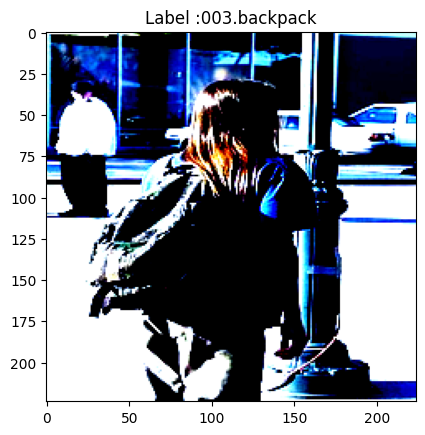

In [58]:
for i in range(232,233):
    image,label = train_data[i]
    plt.imshow(image.permute(1,2,0))
    plt.title("Label :{}".format(train_data.classes[label]))
    plt.show()

In [59]:
batch_size =256
train_loader = DataLoader(train_data,batch_size,shuffle=True, num_workers=4, pin_memory=True)


In [60]:
!pip install torch torchvision torchaudio

In [61]:
torch.cuda.is_available()


True

In [62]:
import torch
print(torch.version.cuda)

12.1


In [63]:
num_classes = len(train_data.classes)
alexnet_model = models.alexnet(pretrained=True)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 139MB/s]  


In [64]:
print(alexnet_model)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [65]:
for param in alexnet_model.parameters():
    param.requires_grad = False
alexnet_model.classifier[6] = nn.Linear(4096, num_classes)
alexnet_model.classifier.add_module("7",nn.LogSoftmax(dim=1))
alexnet_model


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [66]:
loss_func = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(alexnet_model.parameters())
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

model = ResNet50(weights='imagenet')


In [67]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):

    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            loss = loss_criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            train_acc += acc.item() * inputs.size(0)
            

        avg_train_loss = train_loss/len(train_data) 
        avg_train_acc = train_acc/len(train_data) 


        history.append([avg_train_loss, avg_train_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, epoch_end-epoch_start))
    return model, history


In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet_model = alexnet_model.to(device)

num_epochs = 10
model, history = train_and_validate(alexnet_model, loss_func, optimizer, num_epochs)

Epoch: 1/10


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch : 001, Training: Loss: 2.1232, Accuracy: 53.8798%, Time: 191.6393s
Epoch: 2/10
Epoch : 002, Training: Loss: 0.9645, Accuracy: 74.1987%, Time: 133.1979s
Epoch: 3/10
Epoch : 003, Training: Loss: 0.6683, Accuracy: 80.8769%, Time: 133.2991s
Epoch: 4/10
Epoch : 004, Training: Loss: 0.4955, Accuracy: 85.4706%, Time: 133.8953s
Epoch: 5/10
Epoch : 005, Training: Loss: 0.3982, Accuracy: 88.1890%, Time: 154.3402s
Epoch: 6/10
Epoch : 006, Training: Loss: 0.3369, Accuracy: 89.8324%, Time: 147.3926s
Epoch: 7/10
Epoch : 007, Training: Loss: 0.2955, Accuracy: 91.3124%, Time: 145.8249s
Epoch: 8/10
Epoch : 008, Training: Loss: 0.2539, Accuracy: 92.1946%, Time: 139.2146s
Epoch: 9/10
Epoch : 009, Training: Loss: 0.2260, Accuracy: 93.0604%, Time: 140.7097s
Epoch: 10/10
Epoch : 010, Training: Loss: 0.2120, Accuracy: 93.5472%, Time: 140.4096s


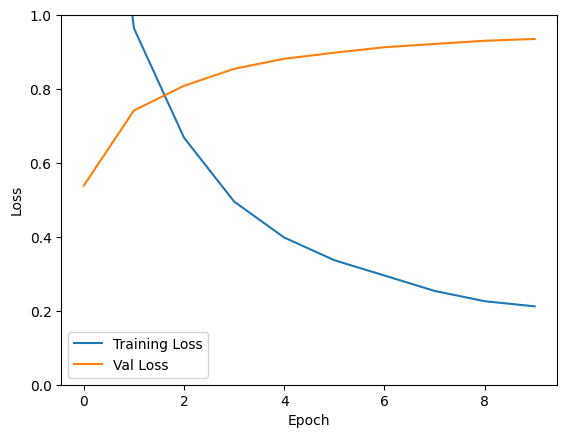

In [69]:
torch.save(alexnet_model.state_dict(), 'alexnet-caltech256.pth')
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

In [235]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
import cv2
import tensorflow as tf

In [236]:
data = pd.read_csv('../input/covid19-ct-scans/metadata.csv')
data.sample(5)
data.head(3)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
1,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...
2,../input/covid19-ct-scans/ct_scans/coronacases...,../input/covid19-ct-scans/lung_mask/coronacase...,../input/covid19-ct-scans/infection_mask/coron...,../input/covid19-ct-scans/lung_and_infection_m...


In [237]:
def read_nii(filepath):

    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array)) #this data needs to rotate 90 degrees 
    return(array)

In [238]:
sample_ct = read_nii(data.loc[0,'ct_scan'])
print (sample_ct.shape)


(512, 512, 301)


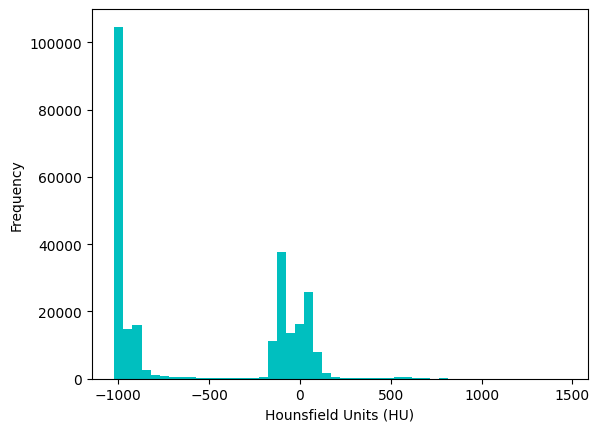

In [239]:
imgs_to_process = sample_ct[...,1]

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [240]:
CT = []
Mask = []
img_size = 128




for case in range(len(data)):
    ct = read_nii(data['ct_scan'][case])
    mask = read_nii(data['infection_mask'][case])
    
    for imgsize in range(ct.shape[2]): 
        
        ct_img = cv2.resize(ct[..., imgsize], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        mask_img = cv2.resize(mask[..., imgsize],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        CT.append(ct_img[..., np.newaxis])
        Mask.append(mask_img[..., np.newaxis])

In [241]:
CT = np.array(CT)
Mask = np.array(Mask)

Text(0.5, 1.0, 'original infection mask')

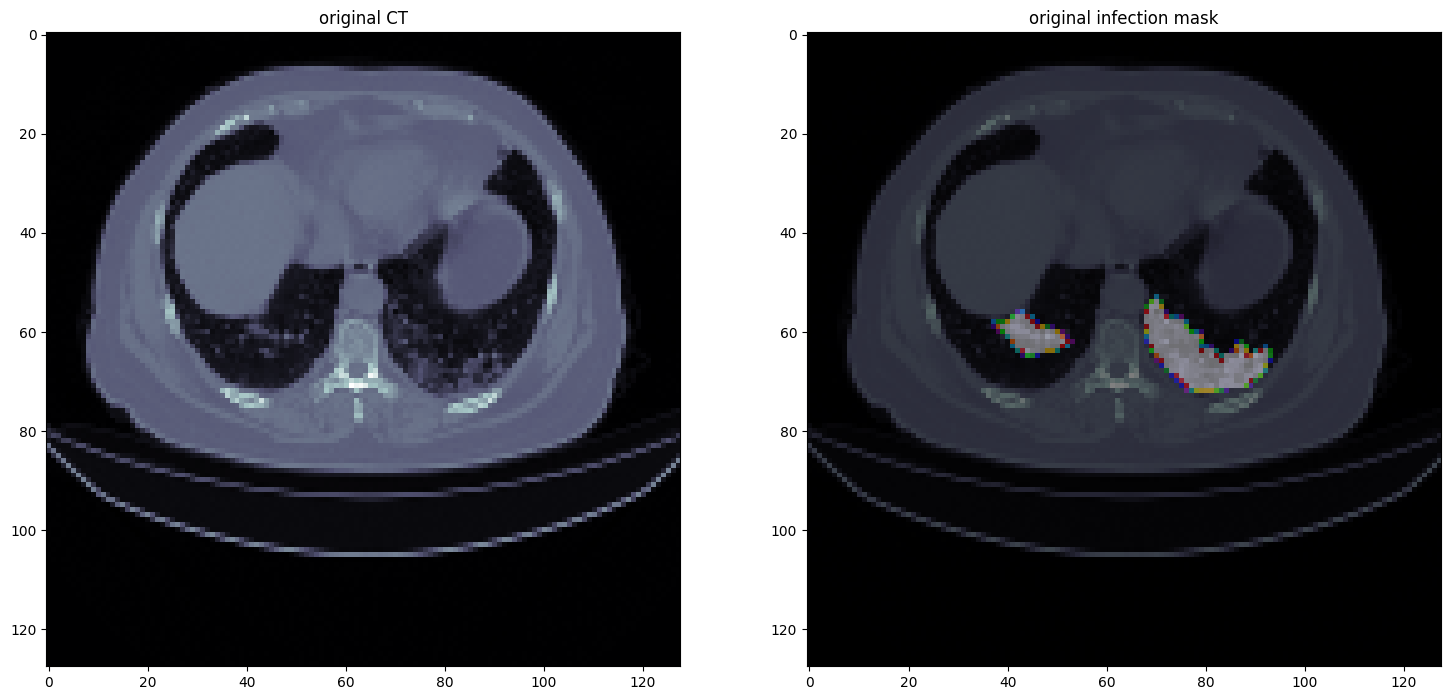

In [242]:
fig = plt.figure(figsize = (18,15))

plt.subplot(1,2,1)
plt.imshow(CT[100][...,0], cmap = 'bone')
plt.title('original CT')

plt.subplot(1,2,2)
plt.imshow(CT[100][...,0], cmap = 'bone')
plt.imshow(Mask[100][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

In [243]:

CT = CT.astype('float32') / 255.0
Mask=Mask.astype('float32')/255.0

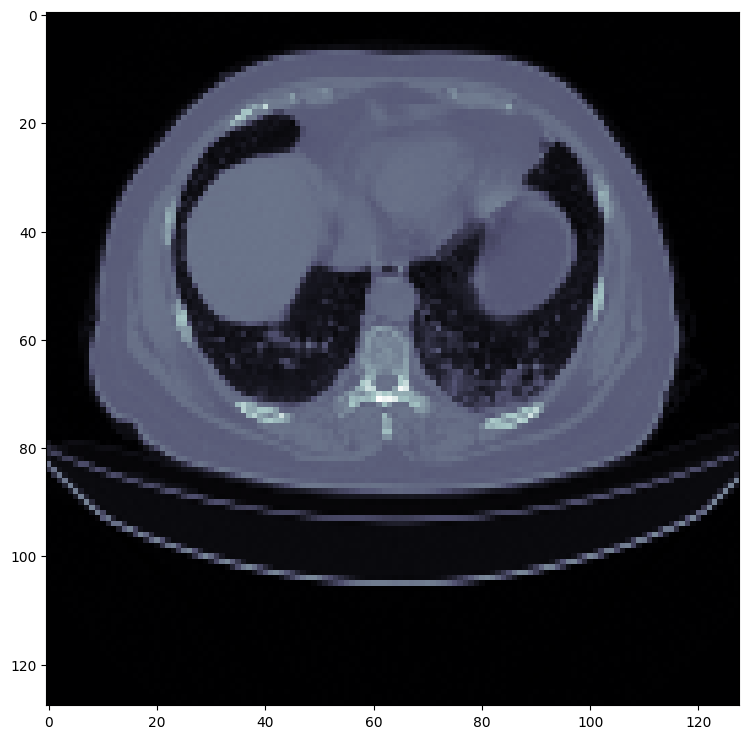

In [244]:
plt.figure(figsize = (9,9))

plt.imshow(norm_data[100][...,0], cmap = 'bone')

In [245]:
from sklearn.model_selection import train_test_split


In [246]:
Mask = Mask.reshape(-1, 128 * 128 * 1) 
Mask = np.argmax(Mask, axis=1)  
CT_train, CT_test, Mask_train, Mask_test = train_test_split(CT, Mask, test_size=0.2, random_state=42)
print(CT.shape)
print(Mask.shape)

(3520, 128, 128, 1)
(3520,)


In [247]:
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
init_1=keras.initializers.VarianceScaling(scale=2.0,mode='fan_avg')

model=keras.models.Sequential([
    keras.layers.Flatten(input_shape=[128,128,1]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100,kernel_initializer=init_1,use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(75,use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dense(10,activation='softmax')
])
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
model = ResNet50(weights='imagenet')



/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [248]:
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_18 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 100)            │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 75)             │         7,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 75)             │           300 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 10)             │           760 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,712,896 (6.53 MB)

 Trainable params: 1,679,778 (6.41 MB)

 Non-trainable params: 33,118 (129.37 KB)

In [249]:
sgd=keras.optimizers.SGD(clipvalue=1)
#tasbite ravande amozesh va jologiri az enfejar shibe yadgiri

In [250]:
#model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

Epoch 1/75
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6998 - loss: 0.9359 - val_accuracy: 0.7967 - val_loss: 0.5585
Epoch 2/75
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8214 - loss: 0.5084 - val_accuracy: 0.8275 - val_loss: 0.4865
Epoch 3/75
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8374 - loss: 0.4610 - val_accuracy: 0.8375 - val_loss: 0.4602
Epoch 4/75
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8484 - loss: 0.4291 - val_accuracy: 0.8332 - val_loss: 0.4664
Epoch 5/75
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8541 - loss: 0.4141 - val_accuracy: 0.8461 - val_loss: 0.4312
Epoch 6/75
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8594 - loss: 0.3971 - val_accuracy: 0.8478 - val_loss: 0.4289
Epoch 7/75
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8630 - loss: 0.3910 - val_accuracy: 0.8470 - val_loss: 0.4287
Epoch 8/75
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8663 - loss: 0.3783 - 

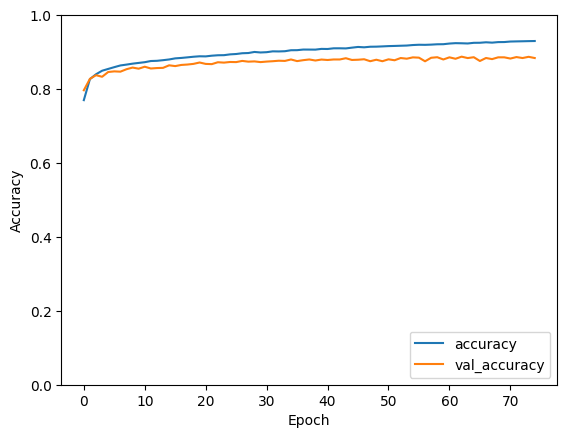

In [266]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, LeakyReLU
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


init_1 = keras.initializers.GlorotUniform()

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[128, 128,1]),
    keras.layers.Dense(100, kernel_initializer=init_1),
    keras.layers.Activation('elu'),
    keras.layers.Dense(75),
    keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer=sgd,metrics=['accuracy'])


history = model.fit(CT_train, Mask_train, epochs=75, validation_data=(CT_test, Mask_test))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()